## 1. Import data and libraries

In [2]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.
warnings.filterwarnings("ignore") 
plt.style.use('fivethirtyeight')

In [3]:
# This option ensures the graphs you create are displayed in your notebook without the need to "call" them specifically.

%matplotlib inline

In [4]:
# Importing file

df = pd.read_csv(r"C:\Users\zwier\anaconda_projects\6.6\Final_Cleaned_EV_Data.csv")

## 2. Subsetting, Wrangling, and Cleaning Time-Series Data

In [6]:
# Reset the index before subsetting
df_reset = df.reset_index()

# List of European Union countries
eu_countries = [
    "Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czech Republic",
    "Denmark", "Estonia", "Finland", "France", "Germany", "Greece", "Hungary",
    "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg", "Malta", "Netherlands",
    "Poland", "Portugal", "Romania", "Slovakia", "Slovenia", "Spain", "Sweden"
]

# Filter for relevant EU countries
df_sub = df_reset[df_reset["region"].isin(eu_countries)]

# Select only relevant parameters (EV stock or EV sales)
df_sub = df_sub[df_sub["parameter"] == "EV stock"]  # Change to "EV sales" if needed

# Select only relevant powertrain type
df_sub = df_sub[df_sub["powertrain"] == "BEV"]  # Change to "EV" or "PHEV" if needed

# Ensure unit is in Vehicles (exclude percentage-based data)
df_sub = df_sub[df_sub["unit"] == "Vehicles"]

# Select only historical years (2012-2023) to avoid forecasted data
df_sub = df_sub[(df_sub["year"] >= 2012) & (df_sub["year"] <= 2023)]

# Aggregate values by year (sum all BEV stocks in EU)
df_eu = df_sub.groupby("year")["value"].sum().reset_index()

# Convert 'year' column back to datetime format and set it as index
df_eu["year"] = pd.to_datetime(df_eu["year"], format="%Y")
df_eu.set_index("year", inplace=True)

# Checking the structure of the new subset
print(df_eu.head())


               value
year                
2012-01-01   32764.0
2013-01-01   58864.0
2014-01-01   95290.0
2015-01-01  147756.0
2016-01-01  206726.0


### Subsetting and Data Selection Rationale

For this step, we aggregated data for the **European Union** by:
- Selecting **only EU countries** as defined by the dataset.
- Focusing on "EV stock" to analyze the adoption of electric vehicles.
- Choosing **Battery Electric Vehicles (BEV)** as the powertrain type of interest.
- Filtering only data expressed in absolute numbers ("Vehicles"), excluding percentage-based data.
- Removing outdated or forecasted values, keeping only historical data from 2012 to 2023.
- **Summing all country-level EV stock values** per year to obtain EU-level insights.

This cleaned dataset allows for a macro-level analysis of EV adoption trends in the European Union.

## 3. Create a line chart of your data

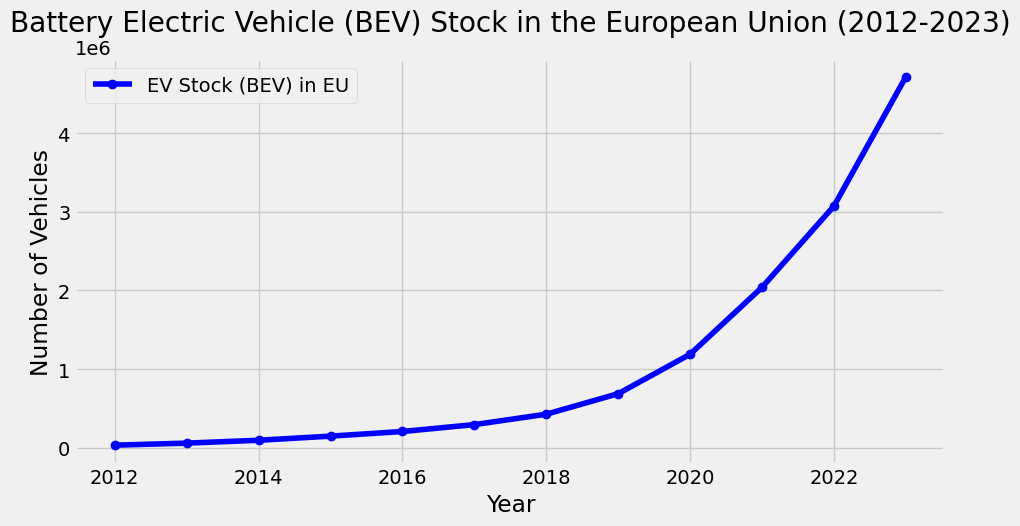

In [9]:
plt.figure(figsize=(10,5))
plt.plot(df_eu.index, df_eu["value"], marker="o", linestyle="-", color="b", label="EV Stock (BEV) in EU")
plt.xlabel("Year")
plt.ylabel("Number of Vehicles")
plt.title("Battery Electric Vehicle (BEV) Stock in the European Union (2012-2023)")
plt.legend()
plt.grid(True)
plt.show()


## 4. Decomposing the Data's Components

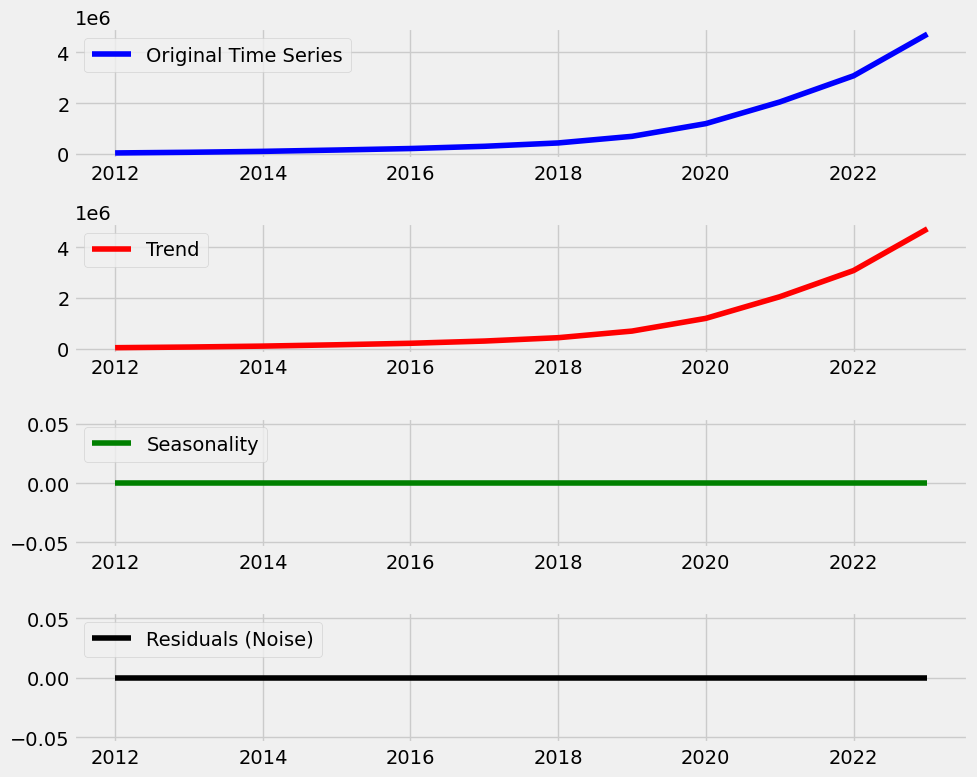

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition (additive model)
decomposition = seasonal_decompose(df_eu["value"], model="additive", period=1)

# Plot the decomposition results
plt.figure(figsize=(10,8))

plt.subplot(4, 1, 1)
plt.plot(df_eu["value"], label="Original Time Series", color="blue")
plt.legend(loc="upper left")

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label="Trend", color="red")
plt.legend(loc="upper left")

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label="Seasonality", color="green")
plt.legend(loc="upper left")

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label="Residuals (Noise)", color="black")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()


### Time Series Decomposition Analysis

The decomposition of the **Battery Electric Vehicle (BEV) stock in the European Union (2012-2023)** reveals the following insights:

- **Trend Component**: The trend shows a **strong upward movement**, indicating a continuous increase in the adoption of BEVs across the EU. The rise is especially noticeable from **2018 onwards**.
- **Seasonality Component**: The seasonal component appears to be negligible, which makes sense given that BEV stock is a cumulative measure rather than a short-term fluctuating metric.
- **Residuals (Noise)**: Some fluctuations in residuals exist, but they are relatively small, suggesting that most of the variability in the dataset is explained by the trend rather than random noise.
- **Conclusion**: The dominant feature of this time series is its **upward trend**, with little evidence of seasonality. This suggests that **forecasting future BEV stock in the EU can primarily rely on trend modeling rather than seasonal adjustments**.

## 5. Conducting the Dickey-Fuller Test for Stationarity

In [14]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test
adf_test = adfuller(df_eu["value"])

# Extract test results
adf_statistic = adf_test[0]
p_value = adf_test[1]
critical_values = adf_test[4]

# Print test results
print("Dickey-Fuller Test Results:")
print(f"ADF Statistic: {adf_statistic}")
print(f"p-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value}")


Dickey-Fuller Test Results:
ADF Statistic: 2.714855092976462
p-value: 0.999087658483652
Critical Values:
   1%: -4.6651863281249994
   5%: -3.3671868750000002
   10%: -2.802960625


### Dickey-Fuller Test Interpretation

The **Augmented Dickey-Fuller (ADF) test** was conducted to assess whether the **Battery Electric Vehicle (BEV) stock in the European Union (2012-2023)** is stationary.

#### **Test Results:**
- **ADF Statistic:** 2.71 (positive, indicating non-stationarity)
- **p-value:** 0.999 (much higher than 0.05, meaning we fail to reject H₀)
- **Critical Values:** The ADF statistic is higher than all critical values (1%, 5%, 10%)

#### **Conclusion:**
- Since **p > 0.05**, we **fail to reject the null hypothesis (H₀)**, meaning the data **is non-stationary**.
- The strong upward trend in BEV stock over time suggests that the dataset follows a **non-stationary process**.
- To perform time-series forecasting, we **need to stationarize the data** by applying techniques such as **differencing**.

## 6. If the data isn’t stationary, conduct a round of differencing.

#### 6.1 First differencing

In [18]:
# Apply first differencing
df_eu["value_diff"] = df_eu["value"] - df_eu["value"].shift(1)

# Remove NaN values resulting from differencing
df_eu.dropna(inplace=True)

# Perform ADF test on differenced data
adf_test_diff = adfuller(df_eu["value_diff"])

# Extract results
adf_statistic_diff = adf_test_diff[0]
p_value_diff = adf_test_diff[1]
critical_values_diff = adf_test_diff[4]

# Print test results
print("Dickey-Fuller Test Results (1st Differencing):")
print(f"ADF Statistic: {adf_statistic_diff}")
print(f"p-value: {p_value_diff}")
print("Critical Values:")
for key, value in critical_values_diff.items():
    print(f"   {key}: {value}")


Dickey-Fuller Test Results (1st Differencing):
ADF Statistic: 2.545450020189651
p-value: 0.9990630561009928
Critical Values:
   1%: -4.9386902332361515
   5%: -3.477582857142857
   10%: -2.8438679591836733


### Dickey-Fuller Test Interpretation (1st Differencing)
**Test Results:**
- **ADF Statistic**: 2.55 (still positive, indicating non-stationarity)
- **p-value**: 0.999 (still > 0.05, meaning we fail to reject H₀)
- **Critical Values**: The ADF statistic is higher than all critical values (1%, 5%, 10%)
**Conclusion:**
- The data remains non-stationary after the first differencing.
- A second round of differencing is required to attempt to stationarize the data.

#### 6.2 Second differencing

In [20]:
# 8. Second differencing to further stationarize the data
df_eu["value_diff2"] = df_eu["value_diff"].diff()

# Remove NaN values resulting from second differencing
df_eu.dropna(inplace=True)

# Perform ADF test on second differenced data
adf_test_diff2 = adfuller(df_eu["value_diff2"])

# Extract results
adf_statistic_diff2 = adf_test_diff2[0]
p_value_diff2 = adf_test_diff2[1]
critical_values_diff2 = adf_test_diff2[4]

# Print test results
print("Dickey-Fuller Test Results (2nd Differencing):")
print(f"ADF Statistic: {adf_statistic_diff2}")
print(f"p-value: {p_value_diff2}")
print("Critical Values:")
for key, value in critical_values_diff2.items():
    print(f"   {key}: {value}")


Dickey-Fuller Test Results (2nd Differencing):
ADF Statistic: 0.9848897087206333
p-value: 0.9941039310737784
Critical Values:
   1%: -5.354256481481482
   5%: -3.6462381481481483
   10%: -2.901197777777778


### Dickey-Fuller Test Interpretation (2nd Differencing)
**Test Results:**
- **ADF Statistic**: 0.98 (still positive, indicating non-stationarity)
- **p-value**: 0.994 (still > 0.05, meaning we fail to reject H₀)
- **Critical Values**: The ADF statistic is higher than all critical values (1%, 5%, 10%)
**Conclusion:**
- The data remains non-stationary even after the second differencing.
- This suggests that differencing alone may not be sufficient to stationarize the data. Alternative transformations (e.g., log transformation, detrending, or seasonal differencing) may be required.

## 7. Check the data’s autocorrelations.

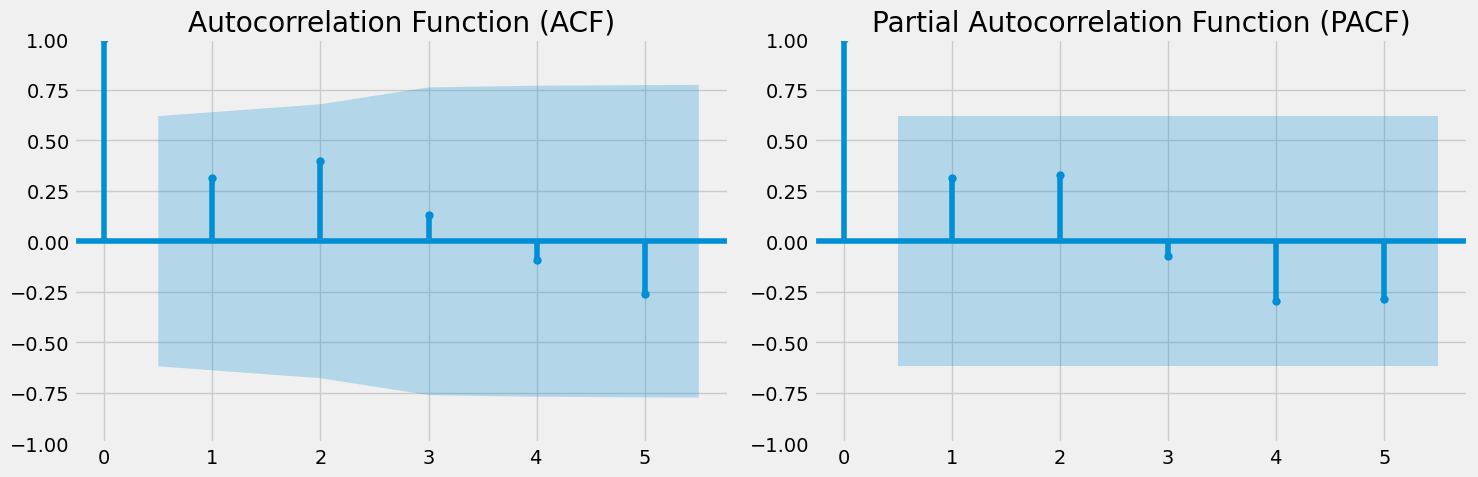

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 9. Checking data’s autocorrelations
fig, axes = plt.subplots(1, 2, figsize=(15,5))

# Check if differenced data is available, otherwise use original
if "value_diff2" in df_eu.columns:
    data_to_use = df_eu["value_diff2"].dropna()  # Ensure no NaN values
else:
    data_to_use = df_eu["value"].dropna()

# Determine the correct number of lags
max_lags = min(20, len(data_to_use) // 2)  # Ensure we don't exceed 50% of sample size

# Autocorrelation plot (ACF)
plot_acf(data_to_use, lags=max_lags, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

# Partial Autocorrelation plot (PACF)
plot_pacf(data_to_use, lags=max_lags, ax=axes[1], method="ywm")
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()


## Interpretation of Autocorrelation (ACF) and Partial Autocorrelation (PACF)

The **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** help in understanding the dependencies in the dataset.

### **1️⃣ ACF Analysis**
- The ACF plot shows **high autocorrelation at lag 1**, and then it gradually decreases.
- This suggests that past values significantly influence future values.
- A slow decay in ACF often indicates **non-stationarity**, which aligns with our previous Dickey-Fuller test results.

### **2️⃣ PACF Analysis**
- The PACF plot shows **significant correlation for the first few lags**, but drops sharply afterward.
- This suggests that the time series may follow an **autoregressive (AR) process**.
- If only the **first lag** is significant, it suggests an **AR(1) process**; if the second is also significant, it suggests an **AR(2) process**.

### **Conclusion**
- The strong autocorrelations confirm that the data exhibits **trend dependence**.
- Given that differencing did not fully stationarize the data, additional transformations (e.g., seasonal differencing, detrending) may be required.
- The identified AR structure can be used for model selection in future forecasting steps (e.g., ARIMA model tuning).

